In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")  # отключаем предупреждения

In [2]:
import pathlib

ROOT_DIR = pathlib.Path().absolute().parent

# EDA
## Medical insurance costs

### Фичи

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance



### Целевой признак

charges (Individual medical costs billed by health insurance)

Цель обучить модель предсказывать значение charges 

### Чтение датасета

[kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance)

In [3]:
df = pd.read_csv(ROOT_DIR / "data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Проверим если есть пропущенные значения

In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропущенных значений нет 

### Анализ признаков

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Charges

Сперва посмотрим на целевой признак

In [6]:
df["charges"].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

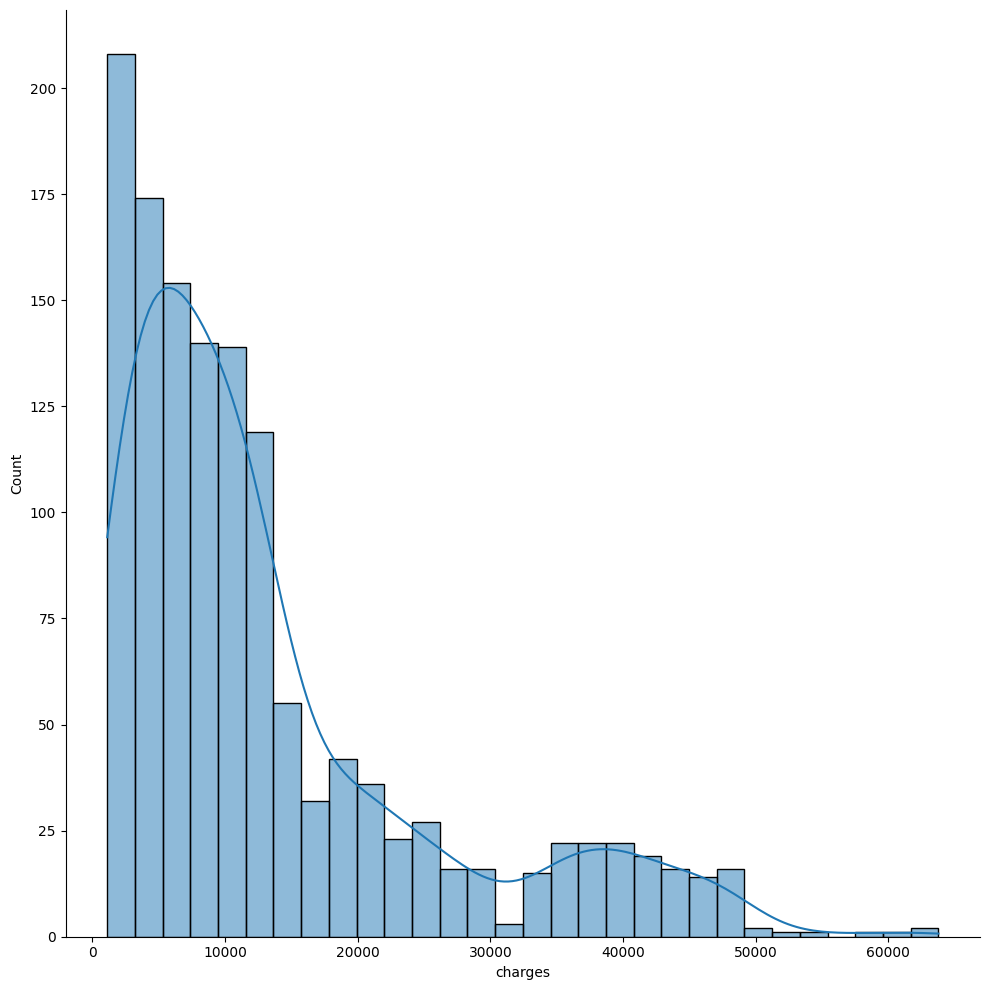

In [7]:
sns.displot(df['charges'], kde=True, height=10);

Пик стоимости страховки приходится на цену приблизительно меньше 150000

#### Age

In [8]:
df['age'].describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

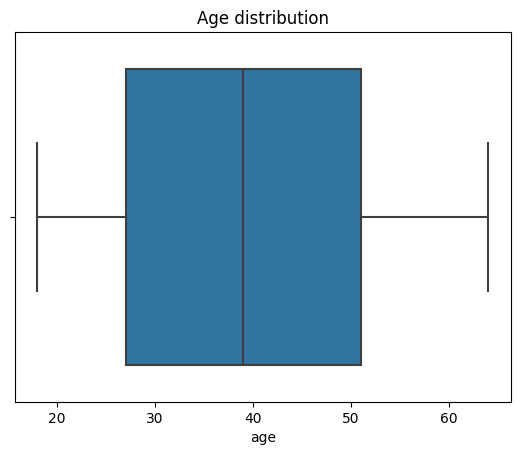

In [9]:
g = sns.boxplot(df.age)
g.set_title("Age distribution");

Медиана приходится на возраст 39 лет. Минимальный возраст -- 18 лет

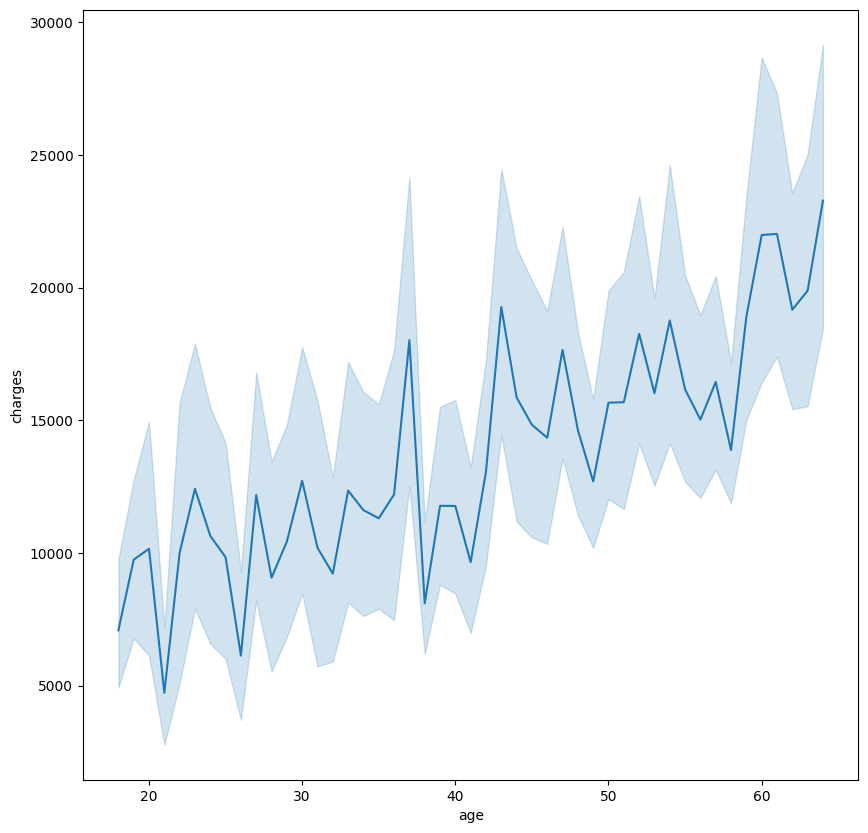

In [10]:
plt.figure(figsize=(10, 10))
sns.lineplot(x="age", y="charges", data=df);

Общая тенденция -- с увеличением возраста стоимость страховки также увеличивается. Хотя как выбросы встречаются высокие значения целевого признака и при меньшем возрасте. Вероятно, на это влияют другие признаки

#### Smoker

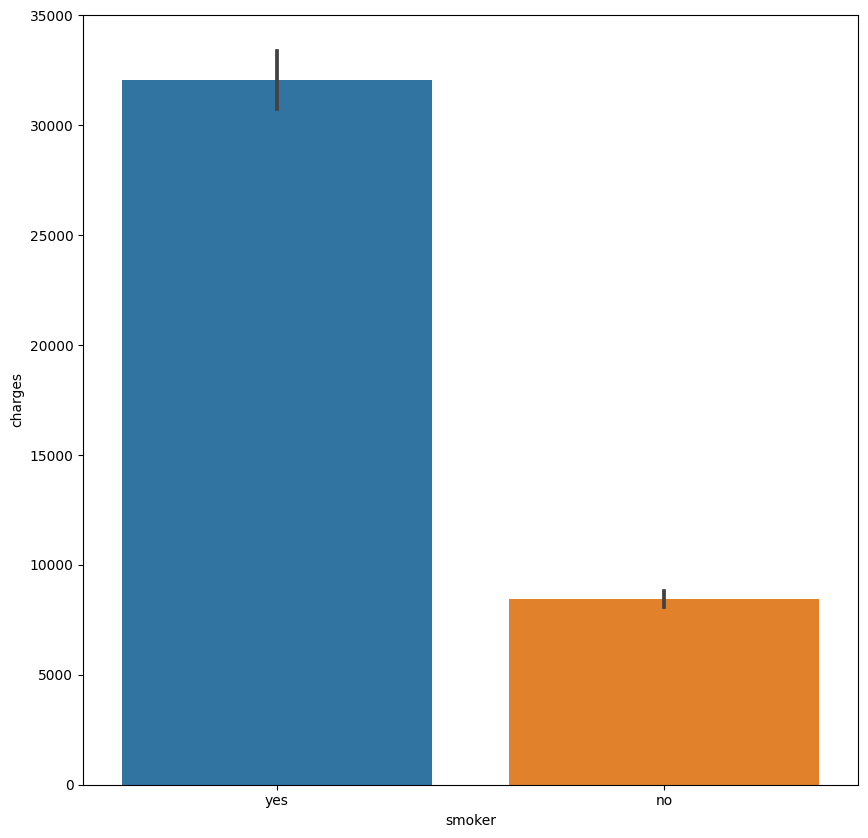

In [11]:
plt.figure(figsize=(10, 10))
sns.barplot(x = 'smoker', y = 'charges', data = df);

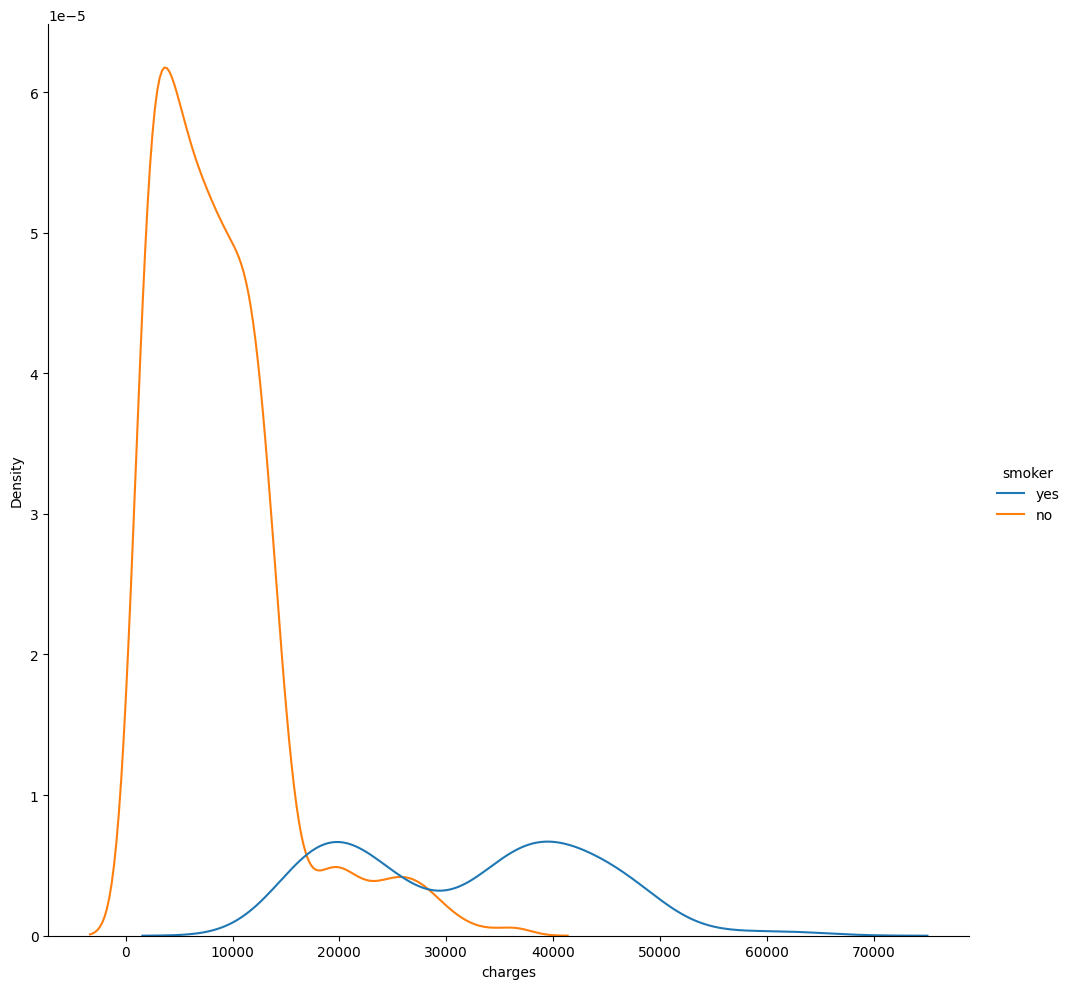

In [12]:
sns.displot(df, x='charges', kind='kde', hue='smoker', height=10);

Цена страховки ниже для некурящих людей. Цена сильно зависит от того курит ли человек или нет 

In [13]:
df["age category"] = "adult"
df.loc[df["age"] < 25, "age category"] = "young"
df.loc[df["age"] >= 60, "age category"] = "senior"

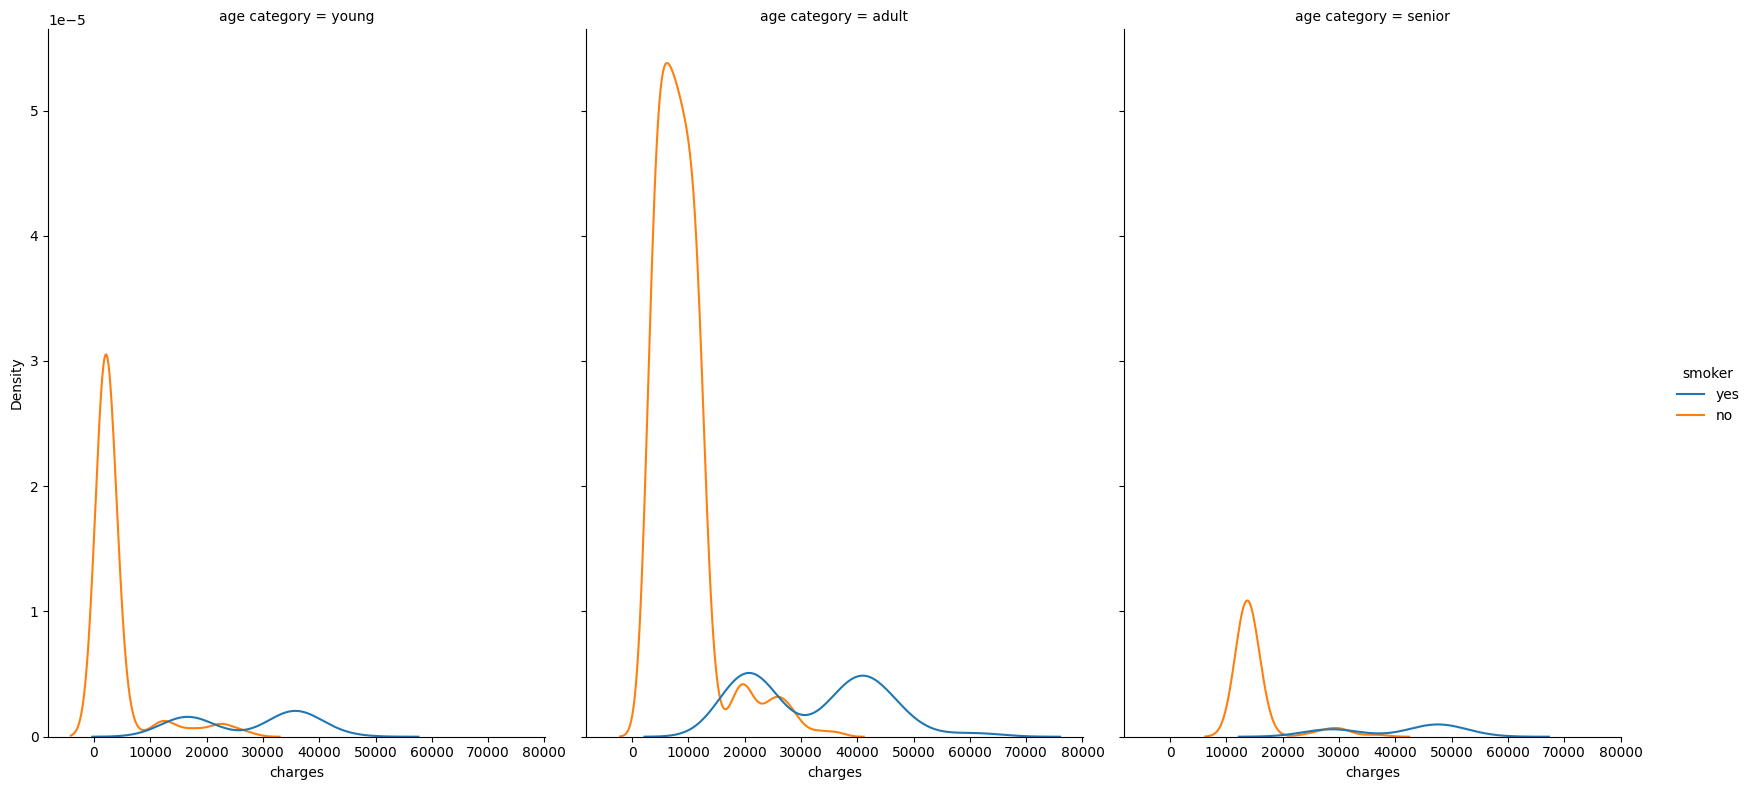

In [14]:
sns.displot(df, x='charges', kind='kde', hue='smoker', col='age category', height=8, aspect=.7);

Независимо от возраста некурящие имеют меньшую стоимость страховки

#### bmi

Разобьём индекс массы тела на группы на основе [таблицы](https://www.forbes.com/health/body/bmi-chart-for-men-and-women/)

In [15]:
df.loc[df["bmi"] < 18.5, "bmi category"] = "underweight"
df.loc[(18.5 <= df["bmi"]) & (df["bmi"] < 24.9), "bmi category"] = "healthy"
df.loc[(24.9 <= df["bmi"]) & (df["bmi"] < 29.9), "bmi category"] = "overweight"
df.loc[df["bmi"] >= 29.9, "bmi category"] = "obesity"

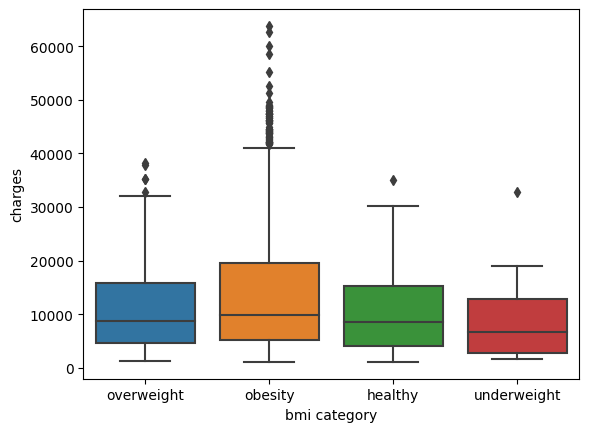

In [16]:
sns.boxplot(x = "bmi category", y = "charges", data = df);

Не похоже, что BMI сильно влияет на стоимость страховки. 

<AxesSubplot: xlabel='children', ylabel='count'>

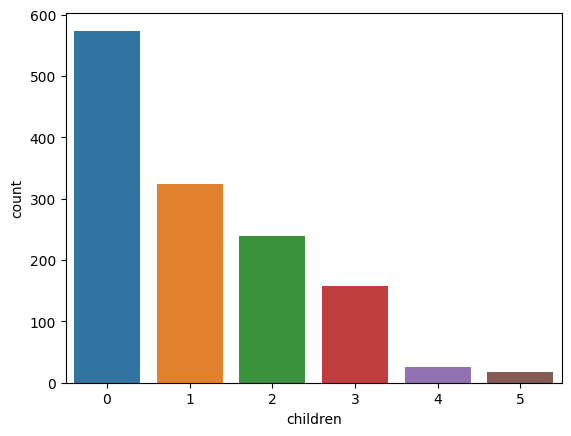

In [17]:
sns.countplot(data=df, x='children')

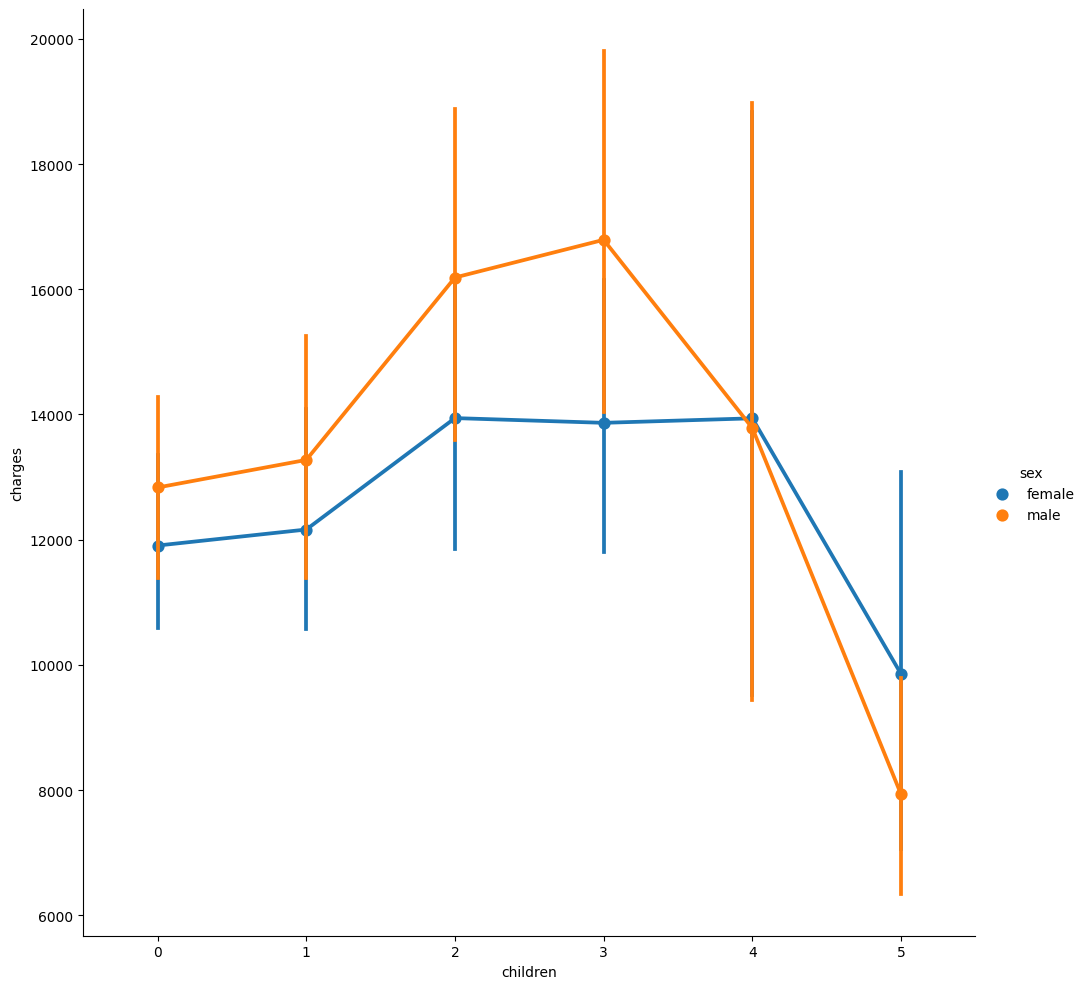

In [18]:
sns.factorplot('children', 'charges', hue='sex', data=df, height=10, aspect=1);

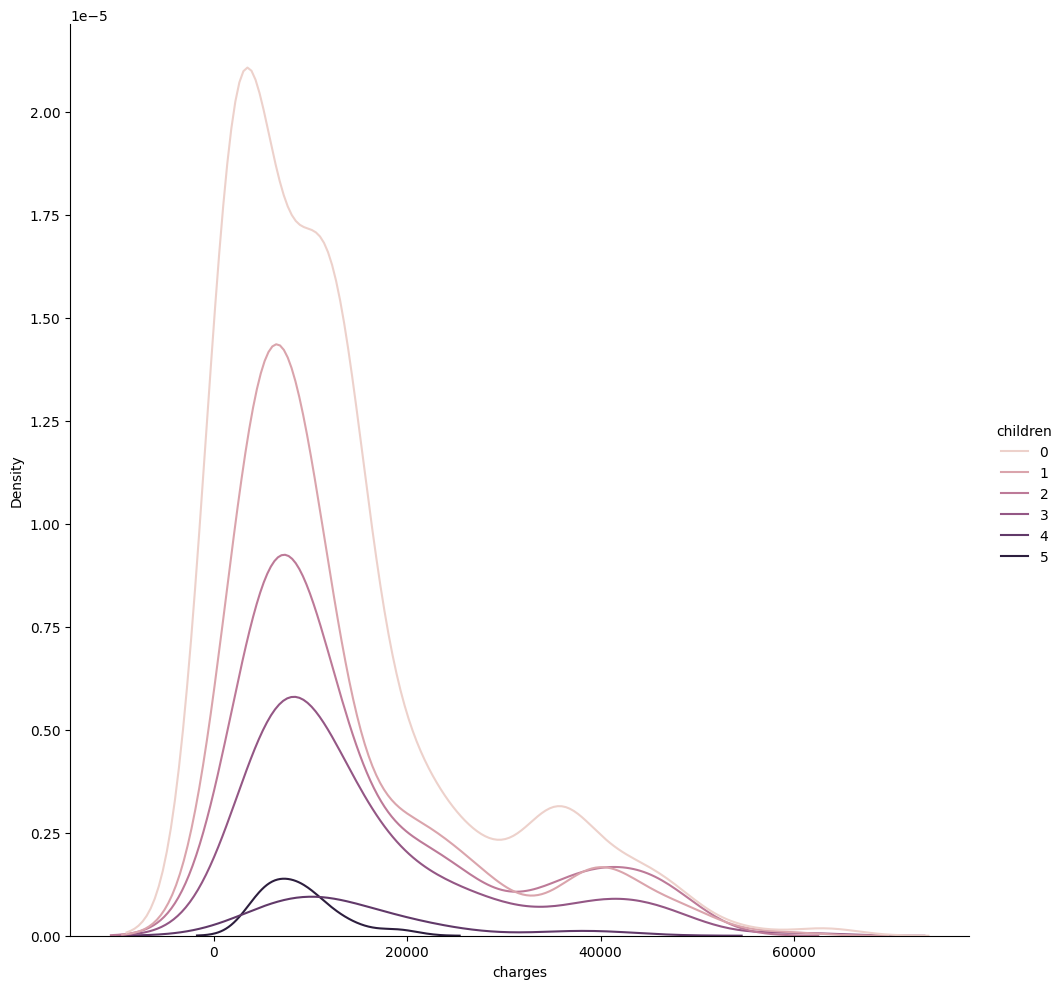

In [19]:
sns.displot(df, x='charges', kind='kde', hue='children', height=10);

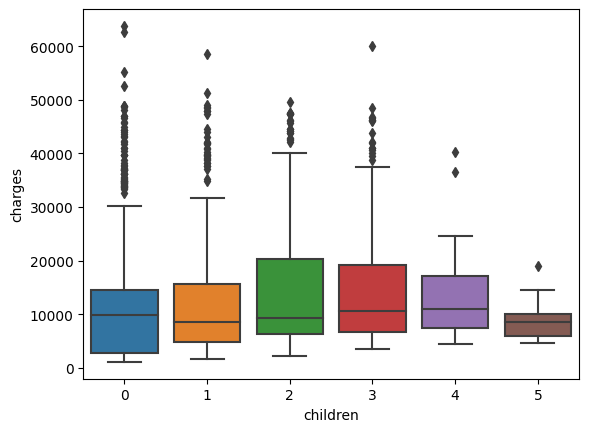

In [20]:
sns.boxplot(x="children", y="charges", data = df);

Количество детей слабо коррелирует с целевым признаком

<AxesSubplot: xlabel='region', ylabel='count'>

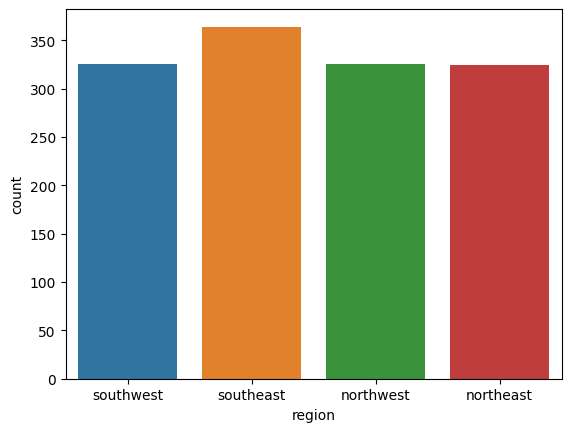

In [21]:
sns.countplot(data=df, x='region')

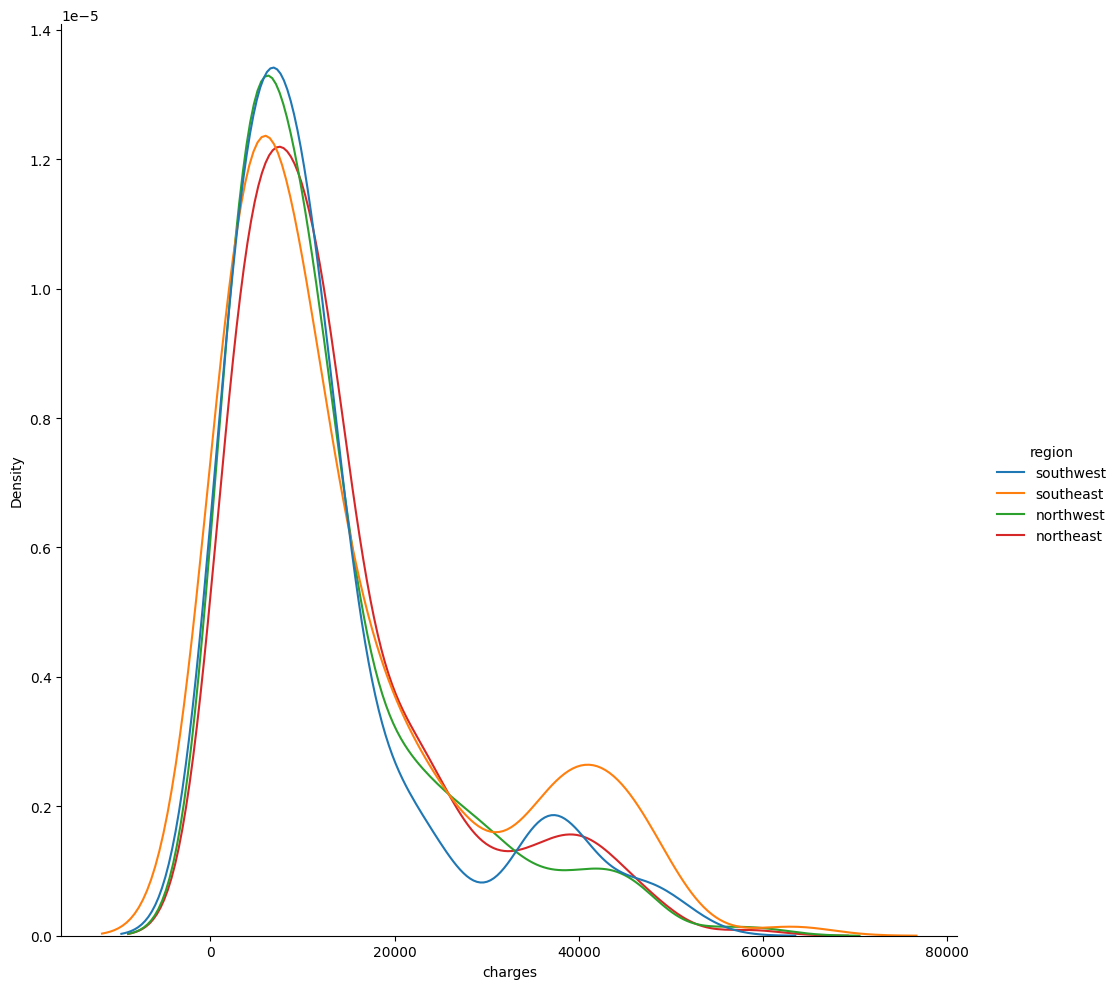

In [22]:
sns.displot(df, x='charges', kind='kde', hue='region', height=10);

Распределение у регионов одинаковое

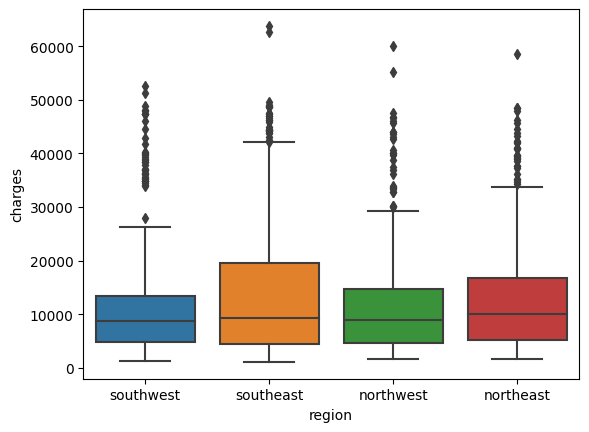

In [23]:
sns.boxplot(x="region", y="charges", data = df);

Видно, что цена страховки не зависит от региона

### Посмотрим на корреляцию признаков

Сперва закодируем категориальный признак smoker

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df.smoker.drop_duplicates()) 
df.smoker = le.transform(df.smoker)

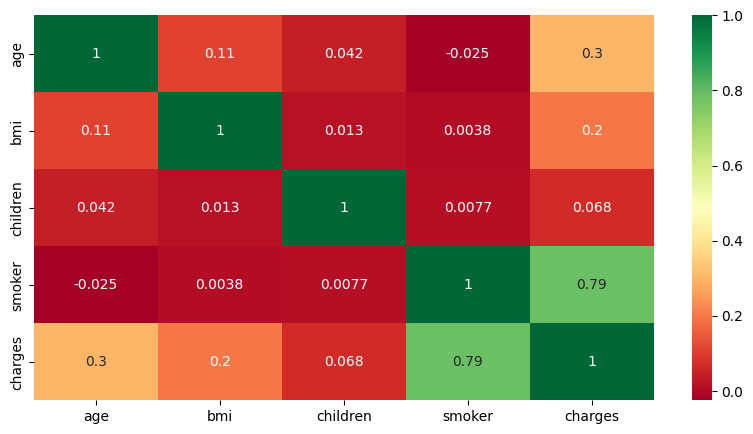

In [25]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Сильную корреляцию видим только с целевого признака с признаком smoker. Остальные признаки между собой слабо коррелируют

### Закодируем признаки 

In [26]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
le.fit(df.sex.drop_duplicates()) 
df.sex = le.transform(df.sex)

ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['region']])
df[ohe.categories_[0]] = transformed.toarray()

In [27]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age category,bmi category,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,southwest,16884.92400,young,overweight,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,southeast,1725.55230,young,obesity,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,southeast,4449.46200,adult,obesity,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,northwest,21984.47061,adult,healthy,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,northwest,3866.85520,adult,overweight,0.0,1.0,0.0,0.0


Выкинем ненужные столбцы из таблицы

In [28]:
df.drop(columns=["region", "age category", "bmi category"], inplace=True)

In [29]:
df.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


# Реализуем свой класс линейной регрессии

In [30]:
import numpy as np

class RidgeRegression():
    
    def __init__(self, alpha=1, lr=0.01, num_steps=100):
        self.alpha=alpha
        self.num_steps=num_steps
        self.lr = lr
        self.w = None
    
    def fit(self,X,y):
        weight = np.zeros(X.shape[1])
        c_prev = 0
        for i in range(self.num_steps):
            weight_prev = weight
            gradient = (1 / X.shape[0]) * (X.T @ (X @ weight - y) + self.alpha * weight)
            weight -= self.lr * gradient

        self.w = weight
    
    def predict(self,X):
        return X @ self.w

# Построение моделей

### Разбиение на Train / Test

In [31]:
from sklearn.model_selection import train_test_split

y = df["charges"]
X = df.drop(columns=["charges"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Отмасштабируем данные

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

### Попробуем избавиться от ненужных признаков с помощью RFE

In [33]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

rfecv = RFECV(estimator=Ridge())

rfecv.fit(X_train_scaled, y_train)

selected_features = rfecv.support_
redundant_features = np.logical_not(selected_features)
redundant_names = [X.columns[i] for i in range(len(X.columns)) if redundant_features[i]]
print(redundant_names)
print(selected_features)

['sex', 'northeast', 'northwest', 'southeast', 'southwest']
[ True False  True  True  True False False False False]


Неудивительно, данные признаки всё равно показывали низкую корреляцию с целевым признаком. 

In [34]:
X_train_scaled = X_train_scaled[:,selected_features]
X_test_scaled = X_test_scaled[:,selected_features]

### Оценим реализованную модель на обучающей и тестовой выборке (MSE, RMSE, $R^2$)

In [35]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

my_model = RidgeRegression(alpha=1e-4, lr=1e-3, num_steps = 1000)

my_model.fit(X_train_scaled, y_train)

y_pred_train = my_model.predict(X_train_scaled)
y_pred_test = my_model.predict(X_test_scaled)

print("[Train] MSE = ", mean_squared_error(y_train, y_pred_train))
print("[Test] MSE = ", mean_squared_error(y_test, y_pred_test))
print("[Train] RMSE = ", mean_squared_error(y_train, y_pred_train, squared=False))
print("[Test] RMSE = ", mean_squared_error(y_test, y_pred_test, squared=False))
print("[Train] R2 = ", r2_score(y_train, y_pred_train))
print("[Test] R2 = ", r2_score(y_test, y_pred_test))

[Train] MSE =  231944471.68326846
[Test] MSE =  222062226.47420946
[Train] RMSE =  15229.723296346145
[Test] RMSE =  14901.752463190678
[Train] R2 =  -0.5835803647407052
[Test] R2 =  -0.5144980369459291


Хорошее значение R2 (:  

Ачивмент гет -- хуже константного предсказателя 

In [36]:
model = Ridge()

model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print("[Train] MSE = ", mean_squared_error(y_train, y_pred_train))
print("[Test] MSE = ", mean_squared_error(y_test, y_pred_test))
print("[Train] RMSE = ", mean_squared_error(y_train, y_pred_train, squared=False))
print("[Test] RMSE = ", mean_squared_error(y_test, y_pred_test, squared=False))
print("[Train] R2 = ", r2_score(y_train, y_pred_train))
print("[Test] R2 = ", r2_score(y_test, y_pred_test))

[Train] MSE =  37883261.85600593
[Test] MSE =  33951616.498453625
[Train] RMSE =  6154.938005862116
[Test] RMSE =  5826.801566764877
[Train] R2 =  0.7413553804833839
[Test] R2 =  0.7684448302871494


### Используем кросс-валидацию

In [37]:
from sklearn.model_selection import cross_validate

scores = ["neg_mean_squared_error", "neg_root_mean_squared_error", "r2"]

cv_scores = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scores, return_train_score=True)

In [38]:
def show_crossval(scores):
    scores.pop('fit_time', None)
    scores.pop('score_time', None)
    data = pd.DataFrame.from_dict(cv_scores)
    for col in data.columns:
        data[col] = -data[col]
    data["test_r2"] = -data["test_r2"]
    data["train_r2"] = -data["train_r2"]
    index = [f"Fold {i + 1}" for i in range(data.shape[0])]
    data = data.append(data.mean(), ignore_index=True)
    index.append("E")
    data = data.append(data.std(), ignore_index=True)
    index.append("STD")
    data.set_index([index], inplace=True)
    return data

In [39]:
show_crossval(cv_scores)

,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
Fold 1,3.648747e+07,3.824592e+07,6040.485780,6184.328361,0.763910,0.735172
Fold 2,3.477848e+07,3.870712e+07,5897.328460,6221.504923,0.801259,0.721333
Fold 3,4.276143e+07,3.682370e+07,6539.222691,6068.253197,0.632439,0.760849
Fold 4,4.172072e+07,3.699844e+07,6459.158161,6082.633991,0.687164,0.752846
Fold 5,3.621009e+07,3.836126e+07,6017.482291,6193.646710,0.759621,0.735795
E,3.839164e+07,3.782729e+07,6190.735477,6150.073436,0.728878,0.741199
STD,3.213030e+06,7.653335e+05,257.749254,62.317120,0.060749,0.014014


Результаты с кросс-валидацией очень похожи на результаты без неё